# GPU Convolution

This notebooks shows how to pefrom the same convolution from the previous notebooks using CUDA Toolkit.

#### from previous notebooks

In [1]:
def image_meta(image_file):
    from PIL import Image
    height = !identify -format '%h' {image_file}
    height = int(height[0])
    width = !identify -format '%w' {image_file}
    width = int(width[0])
    has_alpha_channel = !identify -format '%A' {image_file}
    has_alpha_channel = has_alpha_channel[0]
    channel_cnt = 3
    if has_alpha_channel:
        channel_cnt = 4
    # only 3 channels, red, green, blue, no alpha
    channel_size = width * height
    
    pixels = list(Image.open(image_file).getdata())
    red = list()
    green = list()
    blue = list()
    # will discard alpha channel
    for quadruple in pixels:
        red.append(quadruple[0])
        green.append(quadruple[1])
        blue.append(quadruple[2])
    
    return [height, width, red, green, blue]  

def display_channel(pixels, width):
    from PIL import Image
    height = (int) (len(pixels)/width)
    img = Image.new('L', (width, height))
    img.putdata(pixels)
    display(img)

In [2]:
image_file = './imgs/green_911_turbo_86.jpeg'
[height, width, red,green,blue] = image_meta(image_file)
channel_size = height * width

print('image height  : ', height)
print('image width   : ', width)
print('chanel size   : ', channel_size)
print('total pixels  : ', channel_size * 3) # 3 channels

image height  :  600
image width   :  800
chanel size   :  480000
total pixels  :  1440000


In [3]:
def PY_apply_simple_kernel_func(mat, w, kernel_funct):
    
    # determine height
    h=(int)(len(mat)/w)
    
    # list for convolution
    new_image = list()
    
    # slide window over matrix
    for i,g in enumerate(mat):
    
        # out of bounds?
        if i >= (w*(h-1)): 
            break
        if i!= 0 and (i+1) % w == 0:
            continue
        
        # grab window of pixels
        window = [mat[i], mat[(i+1)], mat[(i+w)], mat[(i+1+w)]]
        
        # apply function
        output = kernel_funct(window)
        
        # round half to even
        output = int(round(output))
        
        # add pixel to convolution
        new_image.append(output)
    return new_image

In [4]:
# recursify the function
def PY_recurse_pooling(mat, width, kernel_funct, recurse_cnt):
    m = mat
    w = width
    for i in range(recurse_cnt):    
        m = PY_apply_simple_kernel_func(m, w, kernel_funct)
        w = w - 1
    return m

### load green channel into pointer array

In [6]:
import ctypes
from ctypes import *
import numpy as np

def GPU_recurse_pooling(mat, width, recurse_cnt, use_max, GPU_pooling):
    height = (int)(len(mat) / width)
    # create pointer array
    ptr_mat = pointer((ctypes.c_int * len(mat))(*mat))
    
    # calculate array size after function call
    returned_height = height - recurse_cnt
    returned_width  = width - recurse_cnt
    returned_convolution_array_size = returned_height * returned_width

    # define return type of integer pointer array
    GPU_pooling.restype = ctypes.POINTER(ctypes.c_int * (returned_convolution_array_size))

    # use mean or max pooling
    f=0
    if use_max:
       f=1     

    # actuall call to GPU code
    ptr_array_convolution = GPU_pooling(ptr_mat, width, height, use_max)
    
    ret_convo = np.ctypeslib.as_array( ptr_array_convolution.contents ,shape=(1,)).astype(int).tolist()   
    # return Python list of convolution pixels
    return ret_convo

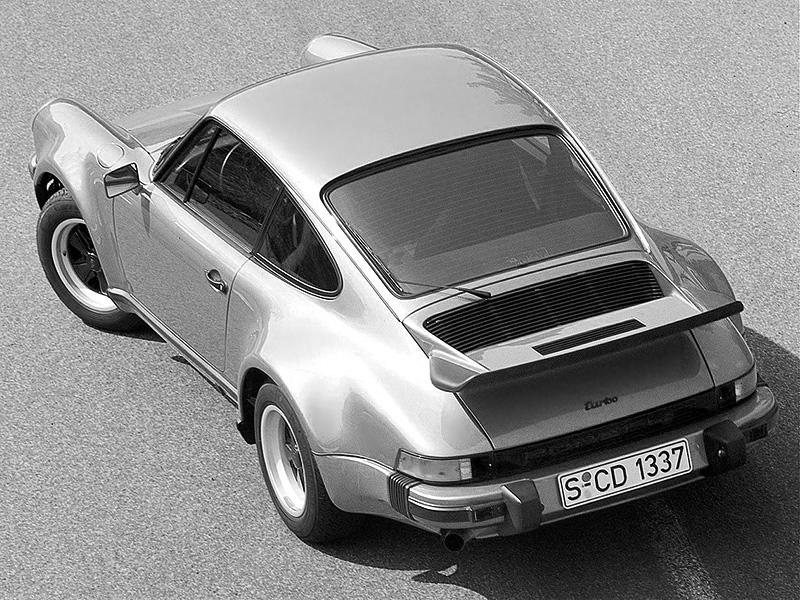

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
display_channel(green,width)

mat = green
w = width
max = 25
use_max = False
recurse_cnt = 1

# create reference to GPU fucntion
GPU_pooling = cdll.LoadLibrary('./gpu/gpu.so').pooling

for i in range(1,max+1,1):
    print(i,', ', end='', flush=True)    
    mat = GPU_recurse_pooling(mat,w,recurse_cnt,use_max, GPU_pooling)
    w = w -1
    if i == max:
        display_channel(mat,w)

In [ ]:
import time

print('mat_size\t,\trecurse_cnt,\tcpp_time,\tpy_time')

for recurse_cnt in [1,5,10,15,20,25]:
    
    print(len(green),  end='', flush=True)
    print('\t\t,\t',   end='', flush=True)
    
    print(recurse_cnt, end='', flush=True)
    print(',\t\t',   end='', flush=True)
    
    start = time.time()
    c_conv = CPP_recurse_pooling(green, width, recurse_cnt, False)    
    secs = round(time.time() - start,2)
    print(secs, end='', flush=True)
    print(',\t\t',   end='', flush=True)
    
    start = time.time()
    p_conv = PY_recurse_pooling(green, width, np.mean, recurse_cnt)    
    secs = round(time.time() - start,2)
    print(secs, end='', flush=True)
        
    print()
    
    if recurse_cnt == 25:
        display_channel(c_conv, width - (recurse_cnt))
        display_channel(p_conv, width - (recurse_cnt))